# 1. ****Customer Purchase Prediction using Multi-Session Behavior****

*This notebook documents the workflow for **MLP Project T22025**, a Kaggle competition aimed at predicting a customer’s purchase value based on their multi-session interactions across various digital touchpoints.*

***Objective:** Build and evaluate a regression model that predicts purchase values using anonymized behavioral data.*

***Dataset:** Includes user sessions with features such as browser types, traffic sources, device details, and geographical indicators.*

***Evaluation Metric:** Submissions are scored using the R² (coefficient of determination) metric.*

***Deliverables:***

1.  Train and test machine learning models.
2.  Generate predictions with “id” and “target” columns.
3.  Submit the final predictions as per the competition requirements.



# 2. **Setup**

# 2.1 Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder,MinMaxScaler
from category_encoders import TargetEncoder


from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 2.2 Reading Datasets

In [2]:
df_train = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
df_test = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

print("shape of df_train is ",df_train.shape)
print("shape of df_test is ",df_test.shape)

shape of df_train is  (116023, 52)
shape of df_test is  (29006, 51)


# 2.3 Dataset summary

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

In [4]:
df_train.head()

trafficSource.isTrueDirect  purchaseValue            browser  \
0                        NaN            0.0               Edge   
1                       True            0.0             Chrome   
2                       True            0.0             Chrome   
3                        NaN            0.0  Internet Explorer   
4                       True     88950000.0             Chrome   

         device.screenResolution trafficSource.adContent  \
0  not available in demo dataset                     NaN   
1  not available in demo dataset                     NaN   
2  not available in demo dataset                     NaN   
3  not available in demo dataset                     NaN   
4  not available in demo dataset                     NaN   

  trafficSource.keyword screenSize geoCluster  \
0                   NaN     medium   Region_2   
1                   NaN     medium   Region_3   
2        (not provided)     medium   Region_2   
3                   NaN     medium   Region_4   
4                   NaN     medium   Region_3   

  trafficSource.adwordsClickInfo.slot    device.mobileDeviceBranding  \
0                                 NaN  not available in demo dataset   
1                                 NaN  not available in demo dataset   
2                                 NaN  not available in demo dataset   
3                                 NaN  not available in demo dataset   
4                                 NaN  not available in demo dataset   

      device.mobileInputSelector  userId trafficSource.campaign  \
0  not available in demo dataset   61421              (not set)   
1  not available in demo dataset   72287              (not set)   
2  not available in demo dataset   25180              (not set)   
3  not available in demo dataset   41295              (not set)   
4  not available in demo dataset  113697              (not set)   

  device.mobileDeviceMarketingName geoNetwork.networkDomain  gclIdPresent  \
0    not available in demo dataset                  domain1             0   
1    not available in demo dataset                  domain3             0   
2    not available in demo dataset                  domain1             0   
3    not available in demo dataset                  domain3             0   
4    not available in demo dataset                  domain1             0   

   device.operatingSystemVersion  sessionNumber  \
0  not available in demo dataset              1   
1  not available in demo dataset              1   
2  not available in demo dataset              2   
3  not available in demo dataset              1   
4  not available in demo dataset              1   

             device.flashVersion              geoNetwork.region trafficSource  \
0  not available in demo dataset                     Washington   youtube.com   
1  not available in demo dataset                     California      (direct)   
2  not available in demo dataset                       Lombardy        google   
3  not available in demo dataset  not available in demo dataset   youtube.com   
4  not available in demo dataset  not available in demo dataset      (direct)   

   totals.visits     geoNetwork.networkLocation   sessionId         os  \
0              1  not available in demo dataset  1500100799    Windows   
1              1  not available in demo dataset  1495262065  Macintosh   
2              1  not available in demo dataset  1508510328    Windows   
3              1  not available in demo dataset  1483431838    Windows   
4              1  not available in demo dataset  1475804633    Windows   

  geoNetwork.subContinent trafficSource.medium  \
0        Northern America             referral   
1        Northern America               (none)   
2         Southern Europe              organic   
3            Eastern Asia             referral   
4        Northern America               (none)   

  trafficSource.adwordsClickInfo.isVideoAd                   browserMajor  \
0                                

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   userChannel                                   29006 non-null  object 
 1   date                                          29006 non-null  int64  
 2   browser                                       29006 non-null  object 
 3   device.browserSize                            29006 non-null  object 
 4   device.browserVersion                         29006 non-null  object 
 5   deviceType                                    29006 non-null  object 
 6   device.flashVersion                           29006 non-null  object 
 7   device.isMobile                               29006 non-null  bool   
 8   device.language                               29006 non-null  object 
 9   device.mobileDeviceBranding                   29006 non-null 

In [6]:
df_test.head()

userChannel      date browser             device.browserSize  \
0          Social  20170508  Chrome  not available in demo dataset   
1  Organic Search  20170405  Chrome  not available in demo dataset   
2  Organic Search  20170308  Safari  not available in demo dataset   
3        Referral  20171113  Chrome  not available in demo dataset   
4  Organic Search  20161212  Chrome  not available in demo dataset   

           device.browserVersion deviceType            device.flashVersion  \
0  not available in demo dataset    desktop  not available in demo dataset   
1  not available in demo dataset    desktop  not available in demo dataset   
2  not available in demo dataset    desktop  not available in demo dataset   
3  not available in demo dataset    desktop  not available in demo dataset   
4  not available in demo dataset    desktop  not available in demo dataset   

   device.isMobile                device.language  \
0            False  not available in demo dataset   
1            False  not available in demo dataset   
2            False  not available in demo dataset   
3            False  not available in demo dataset   
4            False  not available in demo dataset   

     device.mobileDeviceBranding device.mobileDeviceMarketingName  \
0  not available in demo dataset    not available in demo dataset   
1  not available in demo dataset    not available in demo dataset   
2  not available in demo dataset    not available in demo dataset   
3  not available in demo dataset    not available in demo dataset   
4  not available in demo dataset    not available in demo dataset   

        device.mobileDeviceModel     device.mobileInputSelector         os  \
0  not available in demo dataset  not available in demo dataset    Windows   
1  not available in demo dataset  not available in demo dataset    Windows   
2  not available in demo dataset  not available in demo dataset  Macintosh   
3  not available in demo dataset  not available in demo dataset  Chrome OS   
4  not available in demo dataset  not available in demo dataset    Windows   

   device.operatingSystemVersion            device.screenColors  \
0  not available in demo dataset  not available in demo dataset   
1  not available in demo dataset  not available in demo dataset   
2  not available in demo dataset  not available in demo dataset   
3  not available in demo dataset  not available in demo dataset   
4  not available in demo dataset  not available in demo dataset   

         device.screenResolution                geoNetwork.city  \
0  not available in demo dataset  not available in demo dataset   
1  not available in demo dataset                      Palo Alto   
2  not available in demo dataset                   Philadelphia   
3  not available in demo dataset  not available in demo dataset   
4  not available in demo dataset  not available in demo dataset   

  geoNetwork.continent locationCountry                   geoNetwork.metro  \
0             Americas   United States      not available in demo dataset   
1             Americas   United States  San Francisco-Oakland-San Jose CA   
2             Americas   United States                    Philadelphia PA   
3             Americas   United States      not available in demo dataset   
4             Americas   United States      not available in demo dataset   

  geoNetwork.networkDomain     geoNetwork.networkLocation  \
0                  domain2  not available in demo dataset   
1                  domain1  not available in demo dataset   
2                  domain2  not available in demo dataset   
3                  domain2  not available in demo dataset   
4                  domain2  not available in demo dataset   

               geoNetwork.region geoNetwork.subContinent  \
0  not available in demo dataset        Northern America   
1                     California        Northern America   
2                   Pennsylvania        Northern America   
3  not available in demo dataset     

# 3. **EDA and Preprocessing**

# 3.1 Descriptive statistics 

In [7]:
df_train.describe()

purchaseValue         userId   gclIdPresent  sessionNumber  \
count   1.160230e+05  116023.000000  116023.000000  116023.000000   
mean    2.656393e+07   61094.356231       0.037019       2.691311   
std     2.051825e+08   35240.756859       0.188808      10.451613   
min     0.000000e+00       0.000000       0.000000       1.000000   
25%     0.000000e+00   30603.500000       0.000000       1.000000   
50%     0.000000e+00   61014.000000       0.000000       1.000000   
75%     0.000000e+00   91616.500000       0.000000       2.000000   
max     2.312950e+10  122276.000000       1.000000     447.000000   

       totals.visits     sessionId  trafficSource.adwordsClickInfo.page  \
count       116023.0  1.160230e+05                          4281.000000   
mean             1.0  1.493429e+09                             1.019622   
std              0.0  1.528798e+07                             0.174517   
min              1.0  1.470035e+09                             1.000000   
25%              1.0  1.480066e+09                             1.000000   
50%              1.0  1.491646e+09                             1.000000   
75%              1.0  1.505079e+09                             1.000000   
max              1.0  1.525157e+09                             5.000000   

           pageViews  locationZone  totals.bounces          date  \
count  116015.000000      116023.0         47148.0  1.160230e+05   
mean        8.412352           8.0             1.0  2.016860e+07   
std        14.344937           0.0             0.0  6.182322e+03   
min         1.000000           8.0             1.0  2.016080e+07   
25%         1.000000           8.0             1.0  2.016112e+07   
50%         2.000000           8.0             1.0  2.017041e+07   
75%        10.000000           8.0             1.0  2.017091e+07   
max       469.000000           8.0             1.0  2.018043e+07   

           totalHits  sessionStart  new_visits  
count  116023.000000  1.160230e+05     80518.0  
mean       10.607371  1.493429e+09         1.0  
std        19.629576  1.528798e+07         0.0  
min         1.000000  1.470035e+09         1.0  
25%         1.000000  1.480066e+09         1.0  
50%         2.000000  1.491646e+09         1.0  
75%        12.000000  1.505079e+09         1.0  
max       500.000000  1.525157e+09         1.0

In [8]:
df_train.describe(include = 'object')

trafficSource.isTrueDirect browser        device.screenResolution  \
count                       42890  116023                         116023   
unique                          1      34                              1   
top                          True  Chrome  not available in demo dataset   
freq                        42890   84508                         116023   

         trafficSource.adContent trafficSource.keyword screenSize geoCluster  \
count                       2963                 44162     116023     116023   
unique                        53                   566          1          5   
top     Google Merchandise Store        (not provided)     medium   Region_2   
freq                        1410                 39066     116023      23294   

       trafficSource.adwordsClickInfo.slot    device.mobileDeviceBranding  \
count                                 4281                         116023   
unique                                   3                              1   
top                                    Top  not available in demo dataset   
freq                                  2721                         116023   

           device.mobileInputSelector trafficSource.campaign  \
count                          116023                 116023   
unique                              1                     28   
top     not available in demo dataset              (not set)   
freq                           116023                 110280   

       device.mobileDeviceMarketingName geoNetwork.networkDomain  \
count                            116023                   116023   
unique                                1                        3   
top       not available in demo dataset                  domain1   
freq                             116023                    38795   

        device.operatingSystemVersion            device.flashVersion  \
count                          116023                         116023   
unique                              1                              1   
top     not available in demo dataset  not available in demo dataset   
freq                           116023                         116023   

                    geoNetwork.region trafficSource  \
count                          116023        116023   
unique                            388           161   
top     not available in demo dataset        google   
freq                            60138         44332   

           geoNetwork.networkLocation       os geoNetwork.subContinent  \
count                          116023   116023                  116023   
unique                              1       18                      23   
top     not available in demo dataset  Windows        Northern America   
freq                           116023    39135                   63596   

       trafficSource.medium trafficSource.adwordsClickInfo.isVideoAd  \
count                116023                                     4281   
unique                    7                                        1   
top                 organic                                    False   
freq                  40654                                     4281   

                         browserMajor locationCountry  \
count                          116023          116023   
unique                              1             193   
top     not available in demo dataset   United States   
freq                           116023           60369   

                   device.browserSize  \
count                          116023   
unique                              1   
top     not available in demo dataset   
freq                           116023   

       trafficSource.adwordsClickInfo.adNetworkType  socialEngagementType  \
count                                          4281                116023   
unique                                            2                     1   
top                                   Google Search  Not Socially Engaged   
freq    

# 3.2 Checking for null values

In [9]:
df_train.isnull().sum()

trafficSource.isTrueDirect                       73133
purchaseValue                                        0
browser                                              0
device.screenResolution                              0
trafficSource.adContent                         113060
trafficSource.keyword                            71861
screenSize                                           0
geoCluster                                           0
trafficSource.adwordsClickInfo.slot             111742
device.mobileDeviceBranding                          0
device.mobileInputSelector                           0
userId                                               0
trafficSource.campaign                               0
device.mobileDeviceMarketingName                     0
geoNetwork.networkDomain                             0
gclIdPresent                                         0
device.operatingSystemVersion                        0
sessionNumber                                        0
device.fla

<Axes: >

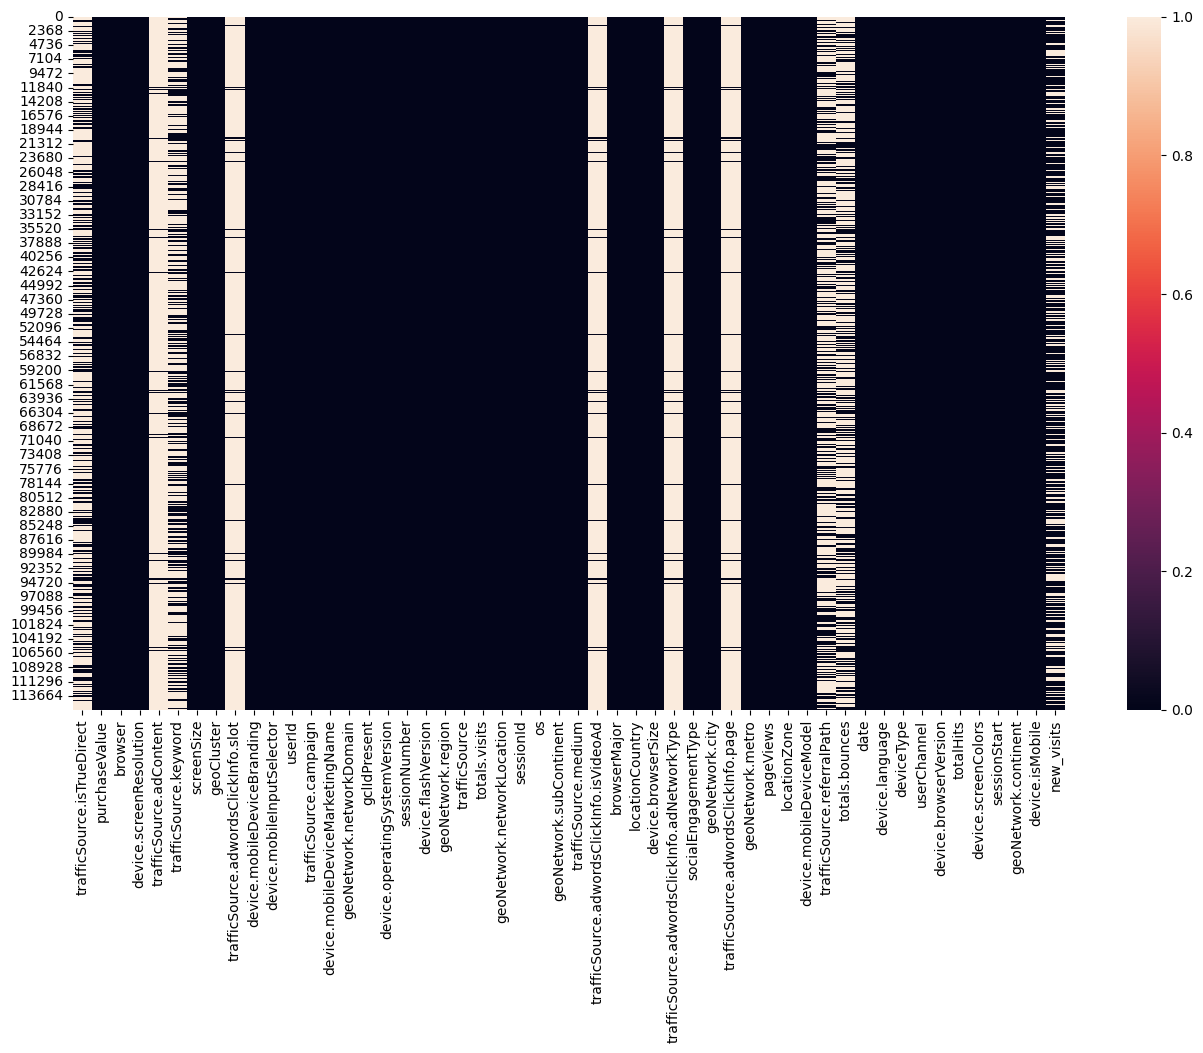

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df_train.isnull())

# 3.3 Droping Columns 

# 3.3.1 Droping userId and sessionId (unique identifier)

In [11]:
df_train.drop(columns = ['userId'],inplace = True)
df_test.drop(columns = ['userId'],inplace = True)
df_train.drop(columns = ['sessionId'],inplace = True)
df_test.drop(columns = ['sessionId'],inplace = True)
print("userId and sessionId are Droped for Train data and test data Successfully")
print("Updated Train Data shape is ",df_train.shape)
print("Updated Test Data shape is ",df_test.shape)

userId and sessionId are Droped for Train data and test data Successfully
Updated Train Data shape is  (116023, 50)
Updated Test Data shape is  (29006, 49)


# 3.3.2 Droping columns having more then 90% Null values¶

In [12]:
missing_percent = (df_train.isnull().sum()/len(df_train)) * 100
missing_percent_90 = missing_percent[missing_percent > 90].index.tolist()
missing_percent[missing_percent>90]

trafficSource.adContent                         97.446196
trafficSource.adwordsClickInfo.slot             96.310214
trafficSource.adwordsClickInfo.isVideoAd        96.310214
trafficSource.adwordsClickInfo.adNetworkType    96.310214
trafficSource.adwordsClickInfo.page             96.310214
dtype: float64

In [13]:
df_train = df_train.drop(columns=missing_percent_90)
df_test = df_test.drop(columns=missing_percent_90)
print("Dropped columns with more than 90% missing values.")
print("New shape of train data is ",df_train.shape)
print("New shape of test data is ",df_test.shape)

Dropped columns with more than 90% missing values.
New shape of train data is  (116023, 45)
New shape of test data is  (29006, 44)


# 3.4 Handeling Numerical Columns

In [14]:
num_col_train = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print('Number of Numerical Features of Train data',len(num_col_train))
print(num_col_train)

print('-')

num_col_test = df_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
print('Number of Numerical Features of Train data',len(num_col_test))
print(num_col_test)

Number of Numerical Features of Train data 11
['purchaseValue', 'gclIdPresent', 'sessionNumber', 'totals.visits', 'pageViews', 'locationZone', 'totals.bounces', 'date', 'totalHits', 'sessionStart', 'new_visits']
-
Number of Numerical Features of Train data 10
['date', 'totals.bounces', 'totalHits', 'new_visits', 'pageViews', 'totals.visits', 'sessionNumber', 'sessionStart', 'locationZone', 'gclIdPresent']


# 3.4.1 Droping columns have only 1 unique value(Numrical)

In [15]:
single_unique_without_null = []
for col in num_col_train:
    if df_train[col].nunique() == 1 and df_train[col].isnull().sum() == 0:
        single_unique_without_null.append(col)


print("Total no of only one unique non-null value columns:", len(single_unique_without_null))            
print("Columns with only one unique non-null value :", single_unique_without_null)

Total no of only one unique non-null value columns: 2
Columns with only one unique non-null value : ['totals.visits', 'locationZone']


# 3.4.2 Numerical Column's Visualization & Imputation

In [16]:
missing_percent_num = (df_train[num_col_train].isnull().sum()/len(df_train)) * 100
missing_percent_num

purchaseValue      0.000000
gclIdPresent       0.000000
sessionNumber      0.000000
totals.visits      0.000000
pageViews          0.006895
locationZone       0.000000
totals.bounces    59.363230
date               0.000000
totalHits          0.000000
sessionStart       0.000000
new_visits        30.601691
dtype: float64

# gclIdPresent       

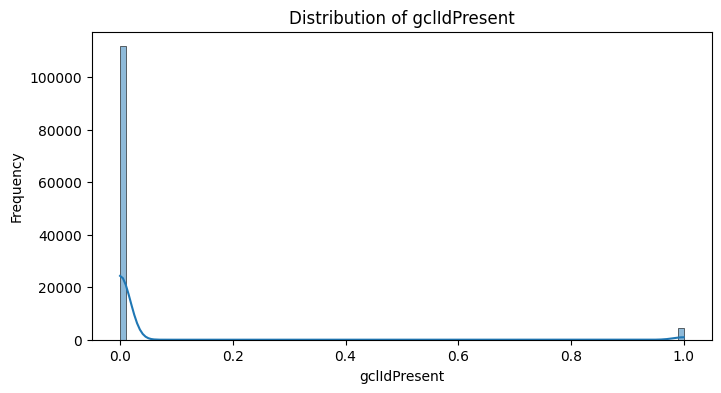

In [17]:
plt.figure(figsize=(8, 4))
sns.histplot(df_train['gclIdPresent'].dropna(), bins=100, kde=True)
plt.title('Distribution of gclIdPresent')
plt.xlabel('gclIdPresent')
plt.ylabel('Frequency')
plt.show()

# sessionNumber

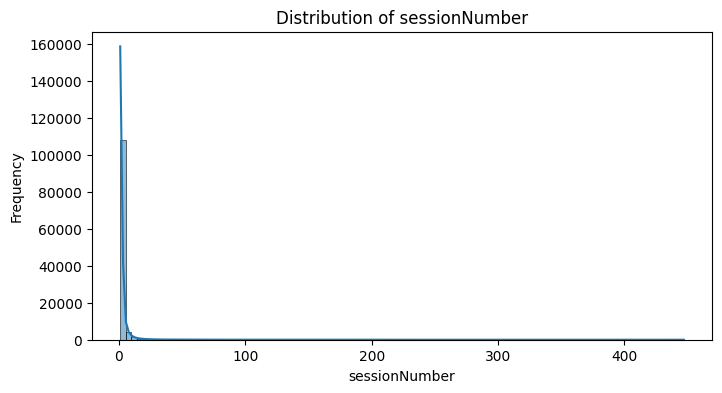

In [18]:
plt.figure(figsize=(8, 4))
sns.histplot(df_train['sessionNumber'].dropna(), bins=100, kde=True)
plt.title('Distribution of sessionNumber')
plt.xlabel('sessionNumber')
plt.ylabel('Frequency')
plt.show()

# pageViews

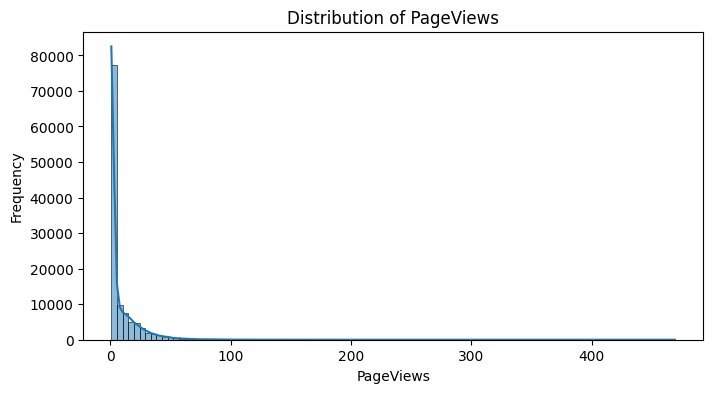

In [19]:
plt.figure(figsize=(8, 4))
sns.histplot(df_train['pageViews'].dropna(), bins=100, kde=True)
plt.title('Distribution of PageViews')
plt.xlabel('PageViews')
plt.ylabel('Frequency')
plt.show()

In [20]:
df_train['pageViews'] = df_train['pageViews'].fillna(0)
df_test['pageViews'] = df_test['pageViews'].fillna(0)

# totalHits

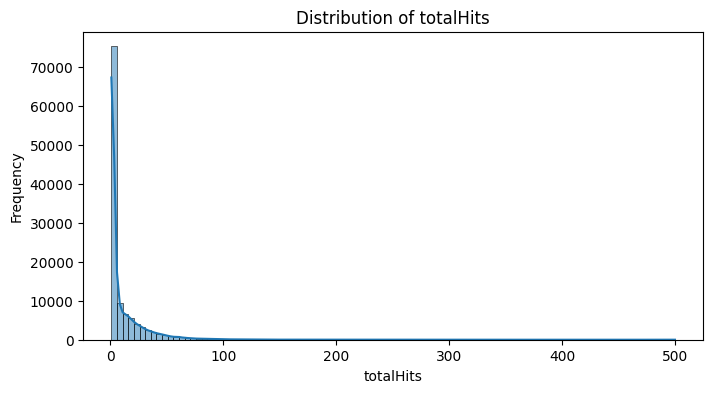

In [21]:
plt.figure(figsize=(8, 4))
sns.histplot(df_train['totalHits'].dropna(), bins=100, kde=True)
plt.title('Distribution of totalHits')
plt.xlabel('totalHits')
plt.ylabel('Frequency')
plt.show()

# totals.bounces

In [22]:
df_train['totals.bounces'].value_counts()

totals.bounces
1.0    47148
Name: count, dtype: int64

In [23]:
df_train['totals.bounces'] = df_train['totals.bounces'].fillna(0)
df_test['totals.bounces'] = df_test['totals.bounces'].fillna(0)

# new_visits

In [24]:
df_train['new_visits'].value_counts()

new_visits
1.0    80518
Name: count, dtype: int64

In [25]:
df_train['new_visits'] = df_train['new_visits'].fillna(0)
df_test['new_visits'] = df_test['new_visits'].fillna(0)

# 3.5 Feature Enginering( Numerical columns)

# date

In [26]:
col = 'date'
df_train[col] = pd.to_datetime(df_train[col], format='%Y%m%d')

df_train['date_year'] = df_train[col].dt.year
df_train['date_month'] = df_train[col].dt.month
df_train['date_day'] = df_train[col].dt.day
df_train['date_weekday'] = df_train[col].dt.weekday
df_train['date_is_weekend'] = df_train['date_weekday'].isin([5, 6]).astype(int)

print(df_train[['date', 'date_year', 'date_month', 'date_day', 'date_weekday', 'date_is_weekend']].head())

print('-')

col = 'date'
df_test[col] = pd.to_datetime(df_test[col], format='%Y%m%d')

df_test['date_year'] = df_test[col].dt.year
df_test['date_month'] = df_test[col].dt.month
df_test['date_day'] = df_test[col].dt.day
df_test['date_weekday'] = df_test[col].dt.weekday
df_test['date_is_weekend'] = df_test['date_weekday'].isin([5, 6]).astype(int)

print(df_test[['date', 'date_year', 'date_month', 'date_day', 'date_weekday', 'date_is_weekend']].head())

        date  date_year  date_month  date_day  date_weekday  date_is_weekend
0 2017-07-14       2017           7        14             4                0
1 2017-05-19       2017           5        19             4                0
2 2017-10-20       2017          10        20             4                0
3 2017-01-03       2017           1         3             1                0
4 2016-10-06       2016          10         6             3                0
-
        date  date_year  date_month  date_day  date_weekday  date_is_weekend
0 2017-05-08       2017           5         8             0                0
1 2017-04-05       2017           4         5             2                0
2 2017-03-08       2017           3         8             2                0
3 2017-11-13       2017          11        13             0                0
4 2016-12-12       2016          12        12             0                0


# sessionStart

In [27]:
df_train['sessionStart_dt'] = pd.to_datetime(df_train['sessionStart'], unit='s')


df_train['session_Hour'] = df_train['sessionStart_dt'].dt.hour
df_train['session_minute'] = df_train['sessionStart_dt'].dt.minute



print(df_train[['session_Hour','session_minute']].head())

print('-')

df_test['sessionStart_dt'] = pd.to_datetime(df_test['sessionStart'], unit='s')

df_test['session_Hour'] = df_test['sessionStart_dt'].dt.hour
df_test['session_minute'] = df_test['sessionStart_dt'].dt.minute



print(df_test[['session_Hour','session_minute']].head())

   session_Hour  session_minute
0             6              39
1             6              34
2            14              38
3             8              23
4             1              43
-
   session_Hour  session_minute
0            16              56
1            23              10
2            19              36
3            17              10
4            16              23


In [28]:
def categorize_hour(hour):
     if 6 <= hour < 12:
        return 'Morning'
     elif 12 <= hour < 18:
        return 'Afternoon'
     elif 18 <= hour < 21:
        return 'Evening'
     else:
        return 'Night'


df_train['session_TimeOfDay'] = df_train['session_Hour'].apply(categorize_hour)
df_test['session_TimeOfDay'] = df_test['session_Hour'].apply(categorize_hour)
print(df_train['session_TimeOfDay'].value_counts())
print('-')
print(df_test['session_TimeOfDay'].value_counts())

session_TimeOfDay
Night        42090
Afternoon    34102
Evening      20137
Morning      19694
Name: count, dtype: int64
-
session_TimeOfDay
Night        10389
Afternoon     8628
Evening       5104
Morning       4885
Name: count, dtype: int64


# Droping (date,sessionStart,sessionStart_dt)

In [29]:
cols_to_drop = ['date', 'sessionStart', 'sessionStart_dt'] 
df_train = df_train.drop(columns=[col for col in cols_to_drop])
df_test = df_test.drop(columns=[col for col in cols_to_drop])
print("Dropped columns:", cols_to_drop)
print('updated shape of train_data ',df_train.shape)
print('updated shape of test_data ',df_test.shape)

Dropped columns: ['date', 'sessionStart', 'sessionStart_dt']
updated shape of train_data  (116023, 51)
updated shape of test_data  (29006, 50)


# totalHits 

In [30]:
df_train['hit_per_page'] = df_train['totalHits'] / (df_train['pageViews'] + 1)
df_train['hit_per_session'] = df_train['totalHits'] / (df_train['sessionNumber'] + 1)

df_test['hit_per_page'] = df_test['totalHits'] / (df_test['pageViews'] + 1)
df_test['hit_per_session'] = df_test['totalHits'] / (df_test['sessionNumber'] + 1)

# 3.6 **Categorical Columns** 

In [31]:
cat_col_train = df_train.select_dtypes(include=['object']).columns.tolist()
print('Number of Categorical Features of Train Data',len(cat_col_train))
print(cat_col_train)

print('-')

cat_col_test = df_test.select_dtypes(include=['object']).columns.tolist()
print('Number of Categorical Features of Test Data',len(cat_col_test))
print(cat_col_test)

Number of Categorical Features of Train Data 34
['trafficSource.isTrueDirect', 'browser', 'device.screenResolution', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'device.operatingSystemVersion', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'geoNetwork.networkLocation', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'browserMajor', 'locationCountry', 'device.browserSize', 'socialEngagementType', 'geoNetwork.city', 'geoNetwork.metro', 'device.mobileDeviceModel', 'trafficSource.referralPath', 'device.language', 'deviceType', 'userChannel', 'device.browserVersion', 'device.screenColors', 'geoNetwork.continent', 'session_TimeOfDay']
-
Number of Categorical Features of Test Data 34
['userChannel', 'browser', 'device.browserSize', 'device.browserVersion', 'deviceType', 'device.flashVersion', 'device.language', 

# 3.6.1 categorical  Column's Visualization & Imputation

In [32]:
missing_percent_cat = df_train[cat_col_train].isnull().sum()/len(df_train)*100
missing_percent_cat

trafficSource.isTrueDirect          63.033192
browser                              0.000000
device.screenResolution              0.000000
trafficSource.keyword               61.936857
screenSize                           0.000000
geoCluster                           0.000000
device.mobileDeviceBranding          0.000000
device.mobileInputSelector           0.000000
trafficSource.campaign               0.000000
device.mobileDeviceMarketingName     0.000000
geoNetwork.networkDomain             0.000000
device.operatingSystemVersion        0.000000
device.flashVersion                  0.000000
geoNetwork.region                    0.000000
trafficSource                        0.000000
geoNetwork.networkLocation           0.000000
os                                   0.000000
geoNetwork.subContinent              0.000000
trafficSource.medium                 0.000000
browserMajor                         0.000000
locationCountry                      0.000000
device.browserSize                

# 3.6.2 Droping feature having constant value

In [33]:
single_unique_without_null = []
for col in cat_col_train:
    if df_train[col].nunique() == 1 and df_train[col].isnull().sum() == 0:
        single_unique_without_null.append(col)


print("Total no of only one unique non-null value columns:", len(single_unique_without_null))            
print("Columns with only one unique non-null value :", single_unique_without_null)

Total no of only one unique non-null value columns: 15
Columns with only one unique non-null value : ['device.screenResolution', 'screenSize', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName', 'device.operatingSystemVersion', 'device.flashVersion', 'geoNetwork.networkLocation', 'browserMajor', 'device.browserSize', 'socialEngagementType', 'device.mobileDeviceModel', 'device.language', 'device.browserVersion', 'device.screenColors']


In [34]:
df_train = df_train.drop(columns=single_unique_without_null)
df_test = df_test.drop(columns=single_unique_without_null)
print("Dropped columns with only one unique value and no nulls.")
print("Update shape of train data ",df_train.shape)
print("Update shape of train data ",df_test.shape)

Dropped columns with only one unique value and no nulls.
Update shape of train data  (116023, 38)
Update shape of train data  (29006, 37)


In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   trafficSource.isTrueDirect  42890 non-null   object 
 1   purchaseValue               116023 non-null  float64
 2   browser                     116023 non-null  object 
 3   trafficSource.keyword       44162 non-null   object 
 4   geoCluster                  116023 non-null  object 
 5   trafficSource.campaign      116023 non-null  object 
 6   geoNetwork.networkDomain    116023 non-null  object 
 7   gclIdPresent                116023 non-null  int64  
 8   sessionNumber               116023 non-null  int64  
 9   geoNetwork.region           116023 non-null  object 
 10  trafficSource               116023 non-null  object 
 11  totals.visits               116023 non-null  int64  
 12  os                          116023 non-null  object 
 13  geoNetwork.sub

# trafficSource.isTrueDirect

In [36]:
df_train['trafficSource.isTrueDirect'].value_counts()

trafficSource.isTrueDirect
True    42890
Name: count, dtype: int64

In [37]:
df_train['trafficSource.isTrueDirect'] = df_train['trafficSource.isTrueDirect'].fillna(False)
df_test['trafficSource.isTrueDirect'] = df_test['trafficSource.isTrueDirect'].fillna(False)

# browser

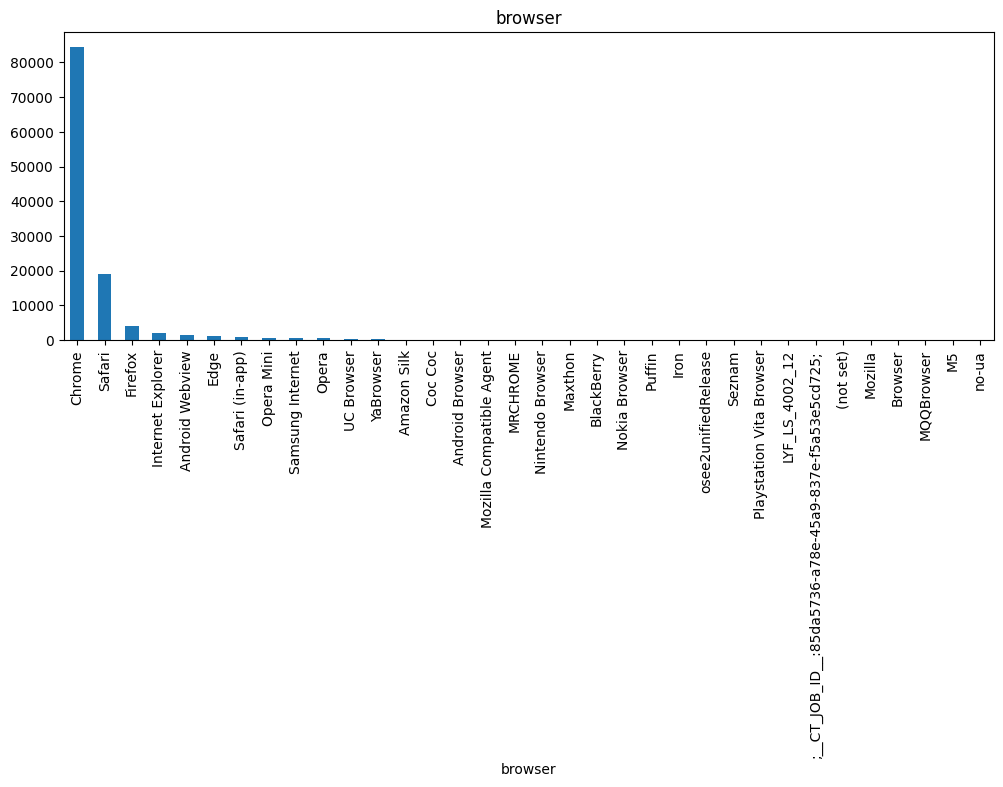

In [38]:
df_train['browser'].value_counts().plot(kind='bar', figsize=(12,4), title='browser')
plt.show()

# trafficSource.keyword

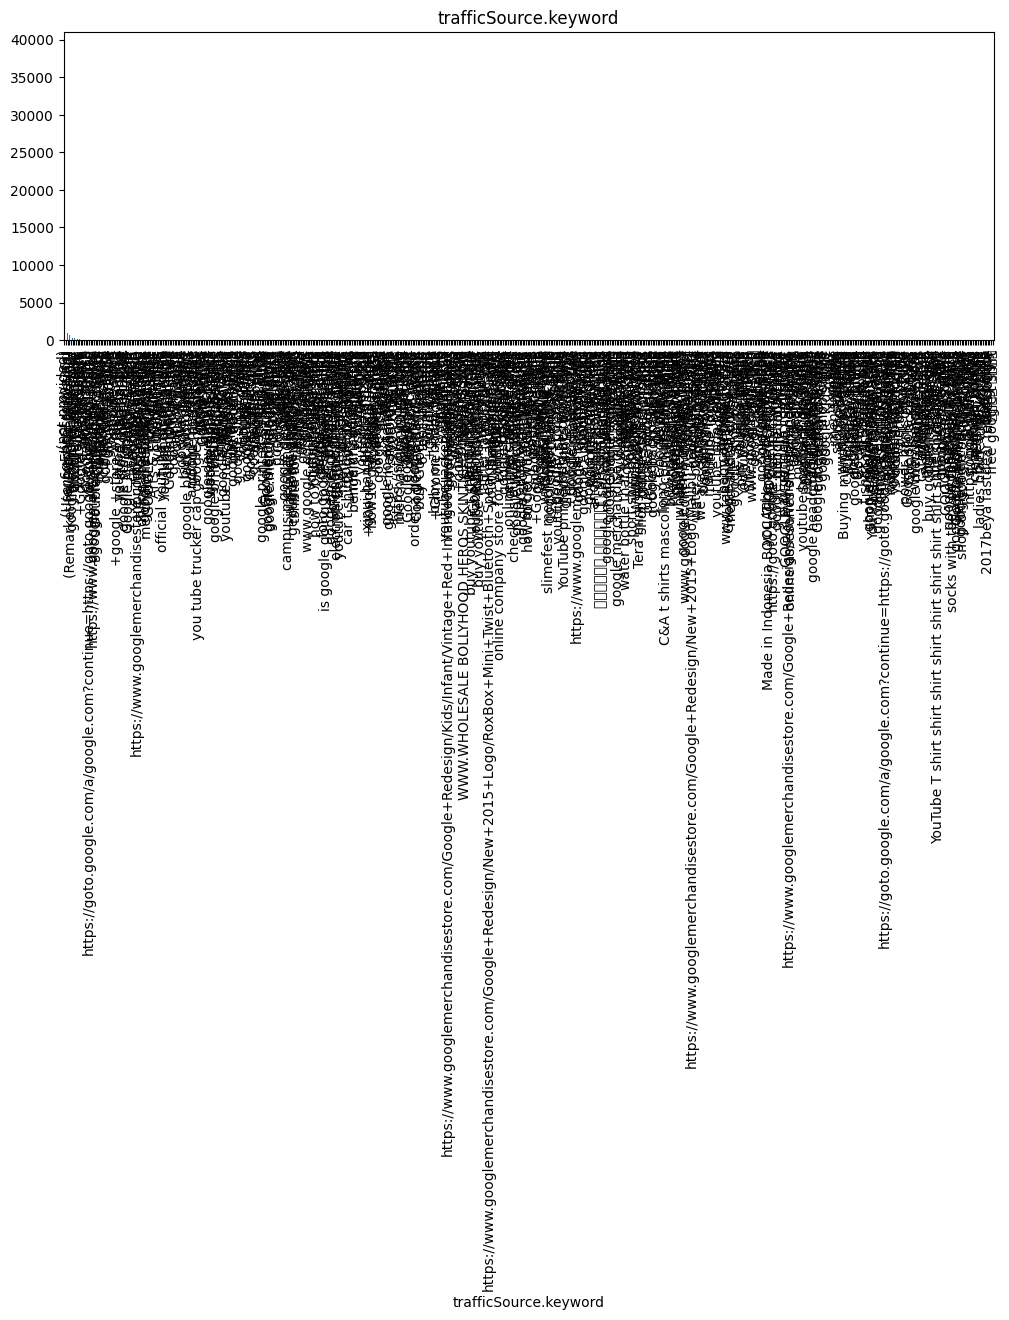

In [39]:
df_train['trafficSource.keyword'].value_counts().plot(kind='bar', figsize=(12,4), title='trafficSource.keyword')
plt.show()

In [40]:
df_train['trafficSource.keyword'] = df_train['trafficSource.keyword'].fillna('unknown')
df_test['trafficSource.keyword'] = df_test['trafficSource.keyword'].fillna('unknown')

# geoCluster

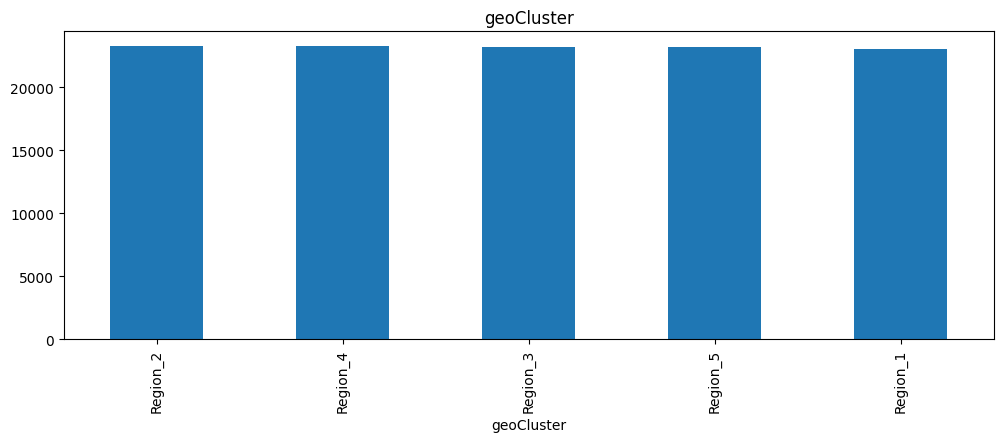

In [41]:
df_train['geoCluster'].value_counts().plot(kind='bar', figsize=(12,4), title='geoCluster')
plt.show()

#  trafficSource.campaign

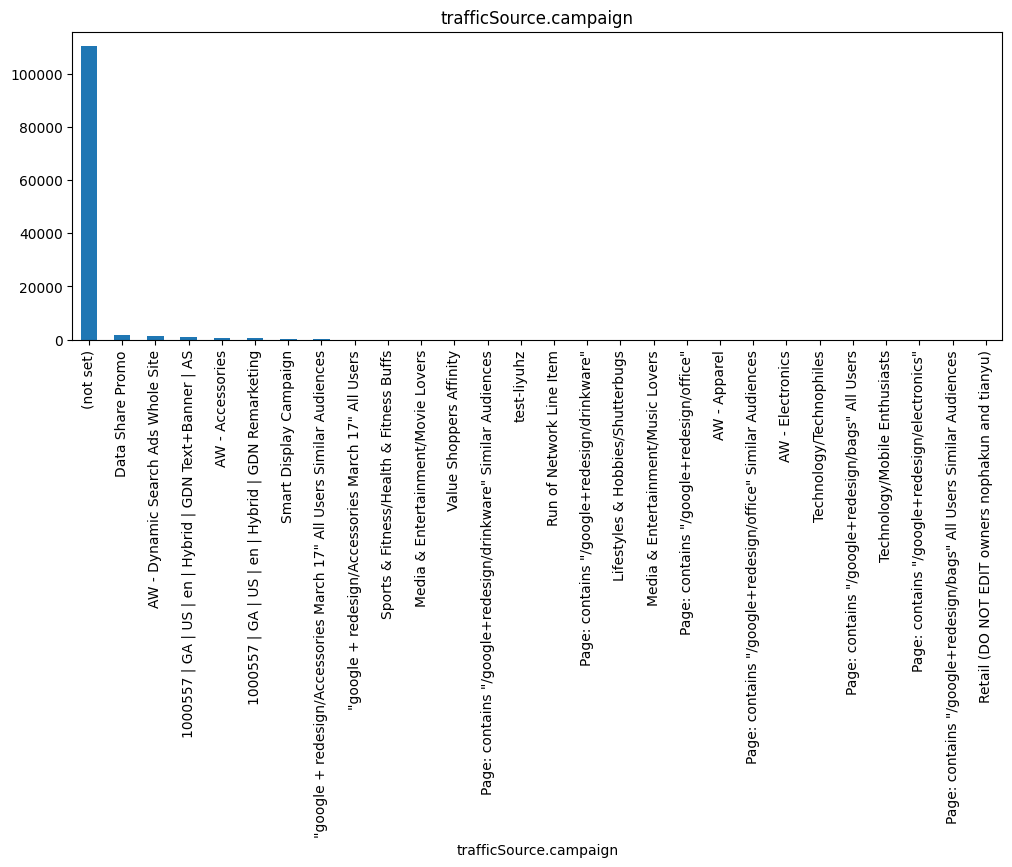

In [42]:
df_train['trafficSource.campaign'].value_counts().plot(kind='bar', figsize=(12,4), title='trafficSource.campaign')
plt.show()

# geoNetwork.networkDomain

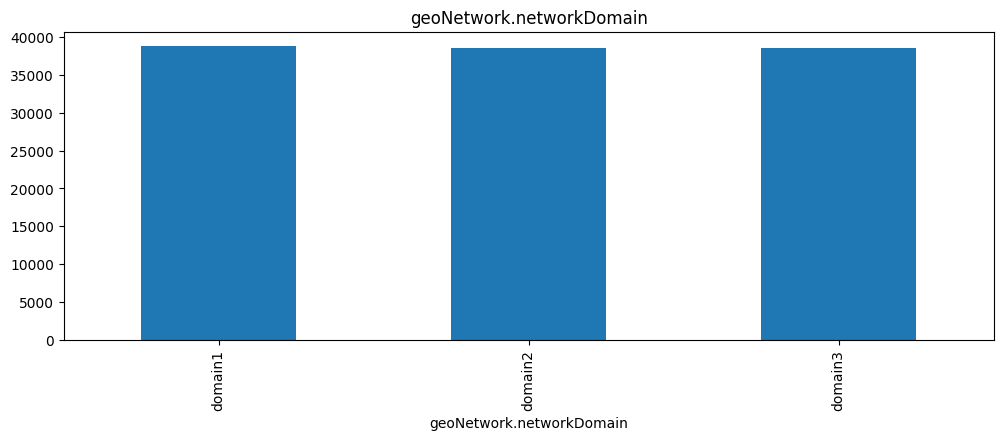

In [43]:
df_train['geoNetwork.networkDomain'].value_counts().plot(kind='bar', figsize=(12,4), title='geoNetwork.networkDomain')
plt.show()

# geoNetwork.region

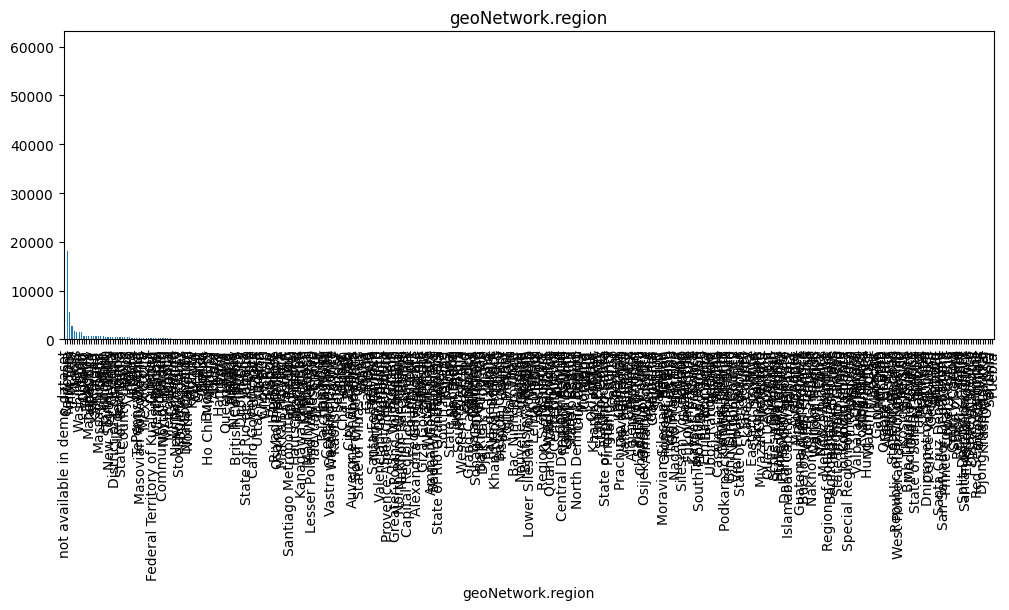

In [44]:
df_train['geoNetwork.region'].value_counts().plot(kind='bar', figsize=(12,4), title='geoNetwork.region')
plt.show()

# trafficSource

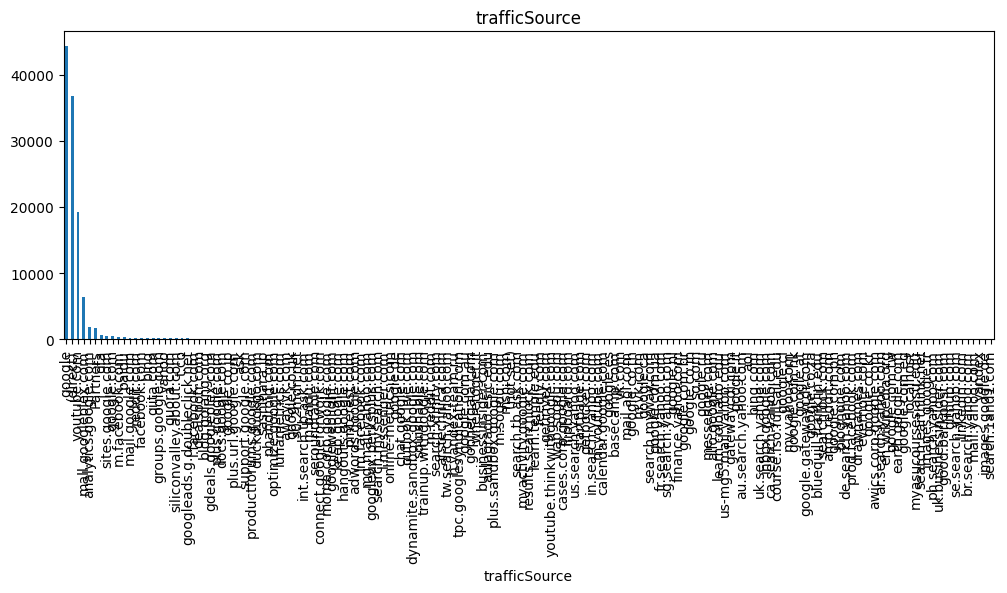

In [45]:
df_train['trafficSource'].value_counts().plot(kind='bar', figsize=(12,4), title='trafficSource')
plt.show()

# os

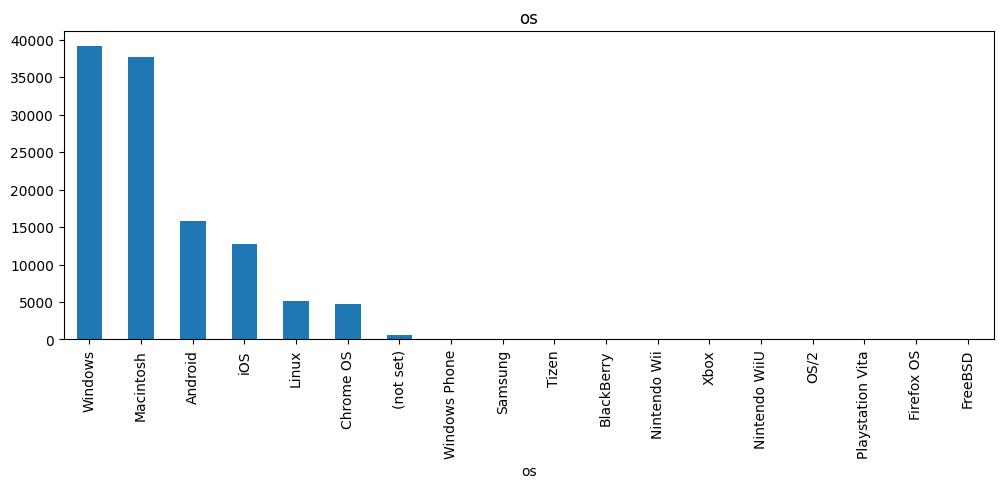

In [46]:
df_train['os'].value_counts().plot(kind='bar', figsize=(12,4), title='os')
plt.show()

# geoNetwork.subContinent

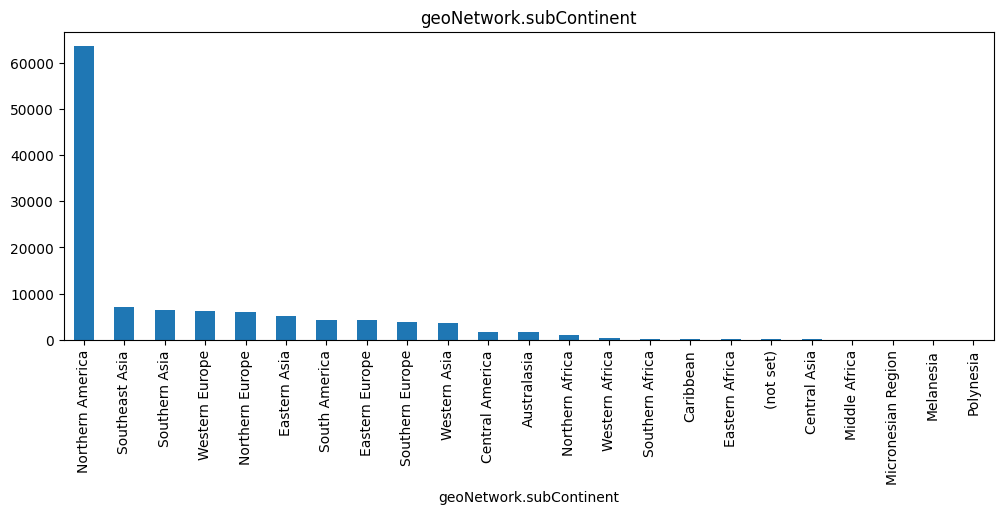

In [47]:
df_train['geoNetwork.subContinent'].value_counts().plot(kind='bar', figsize=(12,4), title='geoNetwork.subContinent')
plt.show()

# trafficSource.medium

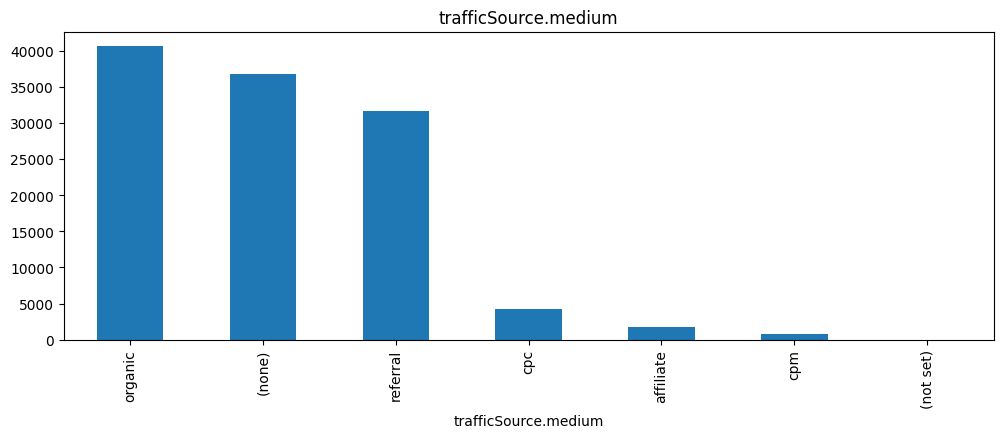

In [48]:
df_train['trafficSource.medium'].value_counts().plot(kind='bar', figsize=(12,4), title='trafficSource.medium')
plt.show()

# locationCountry

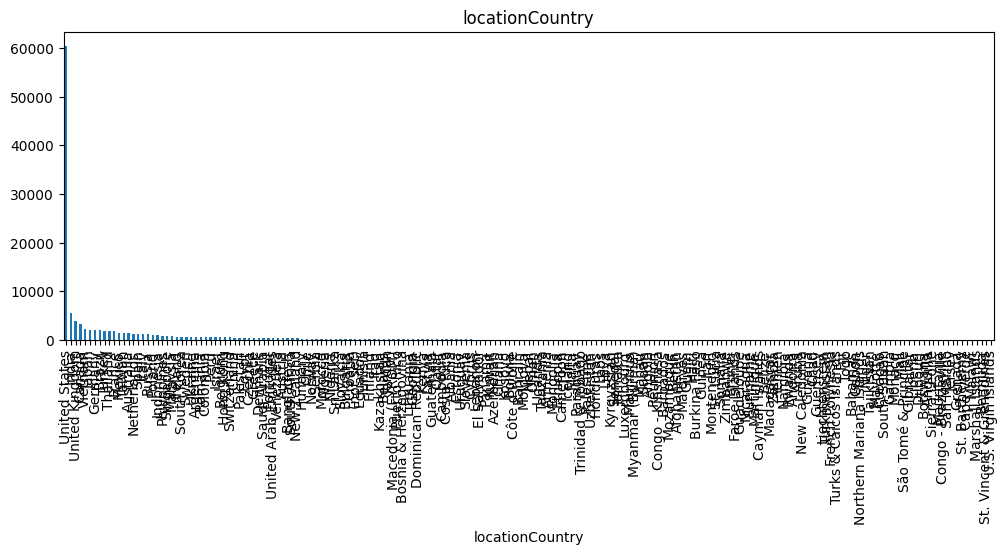

In [49]:
df_train['locationCountry'].value_counts().plot(kind='bar', figsize=(12,4), title='locationCountry')
plt.show()

# geoNetwork.city

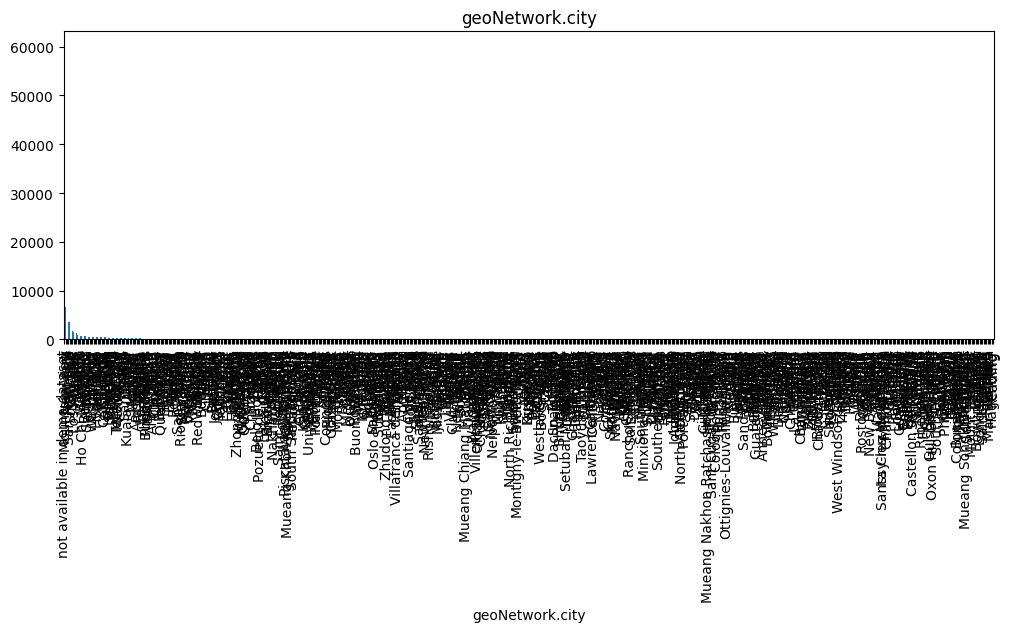

In [50]:
df_train['geoNetwork.city'].value_counts().plot(kind='bar', figsize=(12,4), title='geoNetwork.city')
plt.show()

# geoNetwork.metro

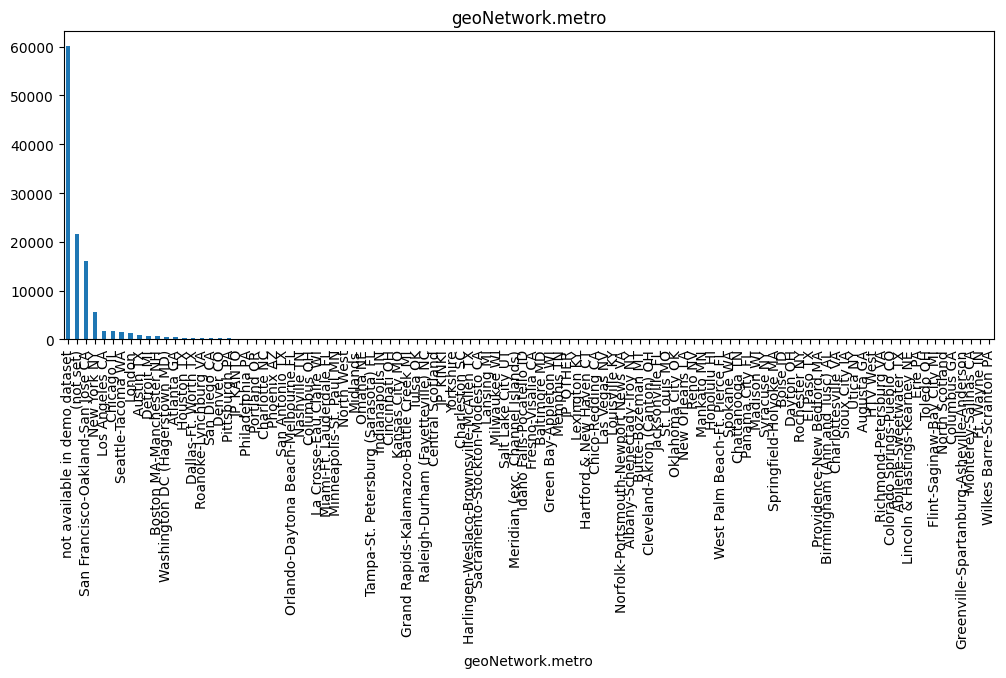

In [51]:
df_train['geoNetwork.metro'].value_counts().plot(kind='bar', figsize=(12,4), title='geoNetwork.metro')
plt.show()

# trafficSource.referralPath

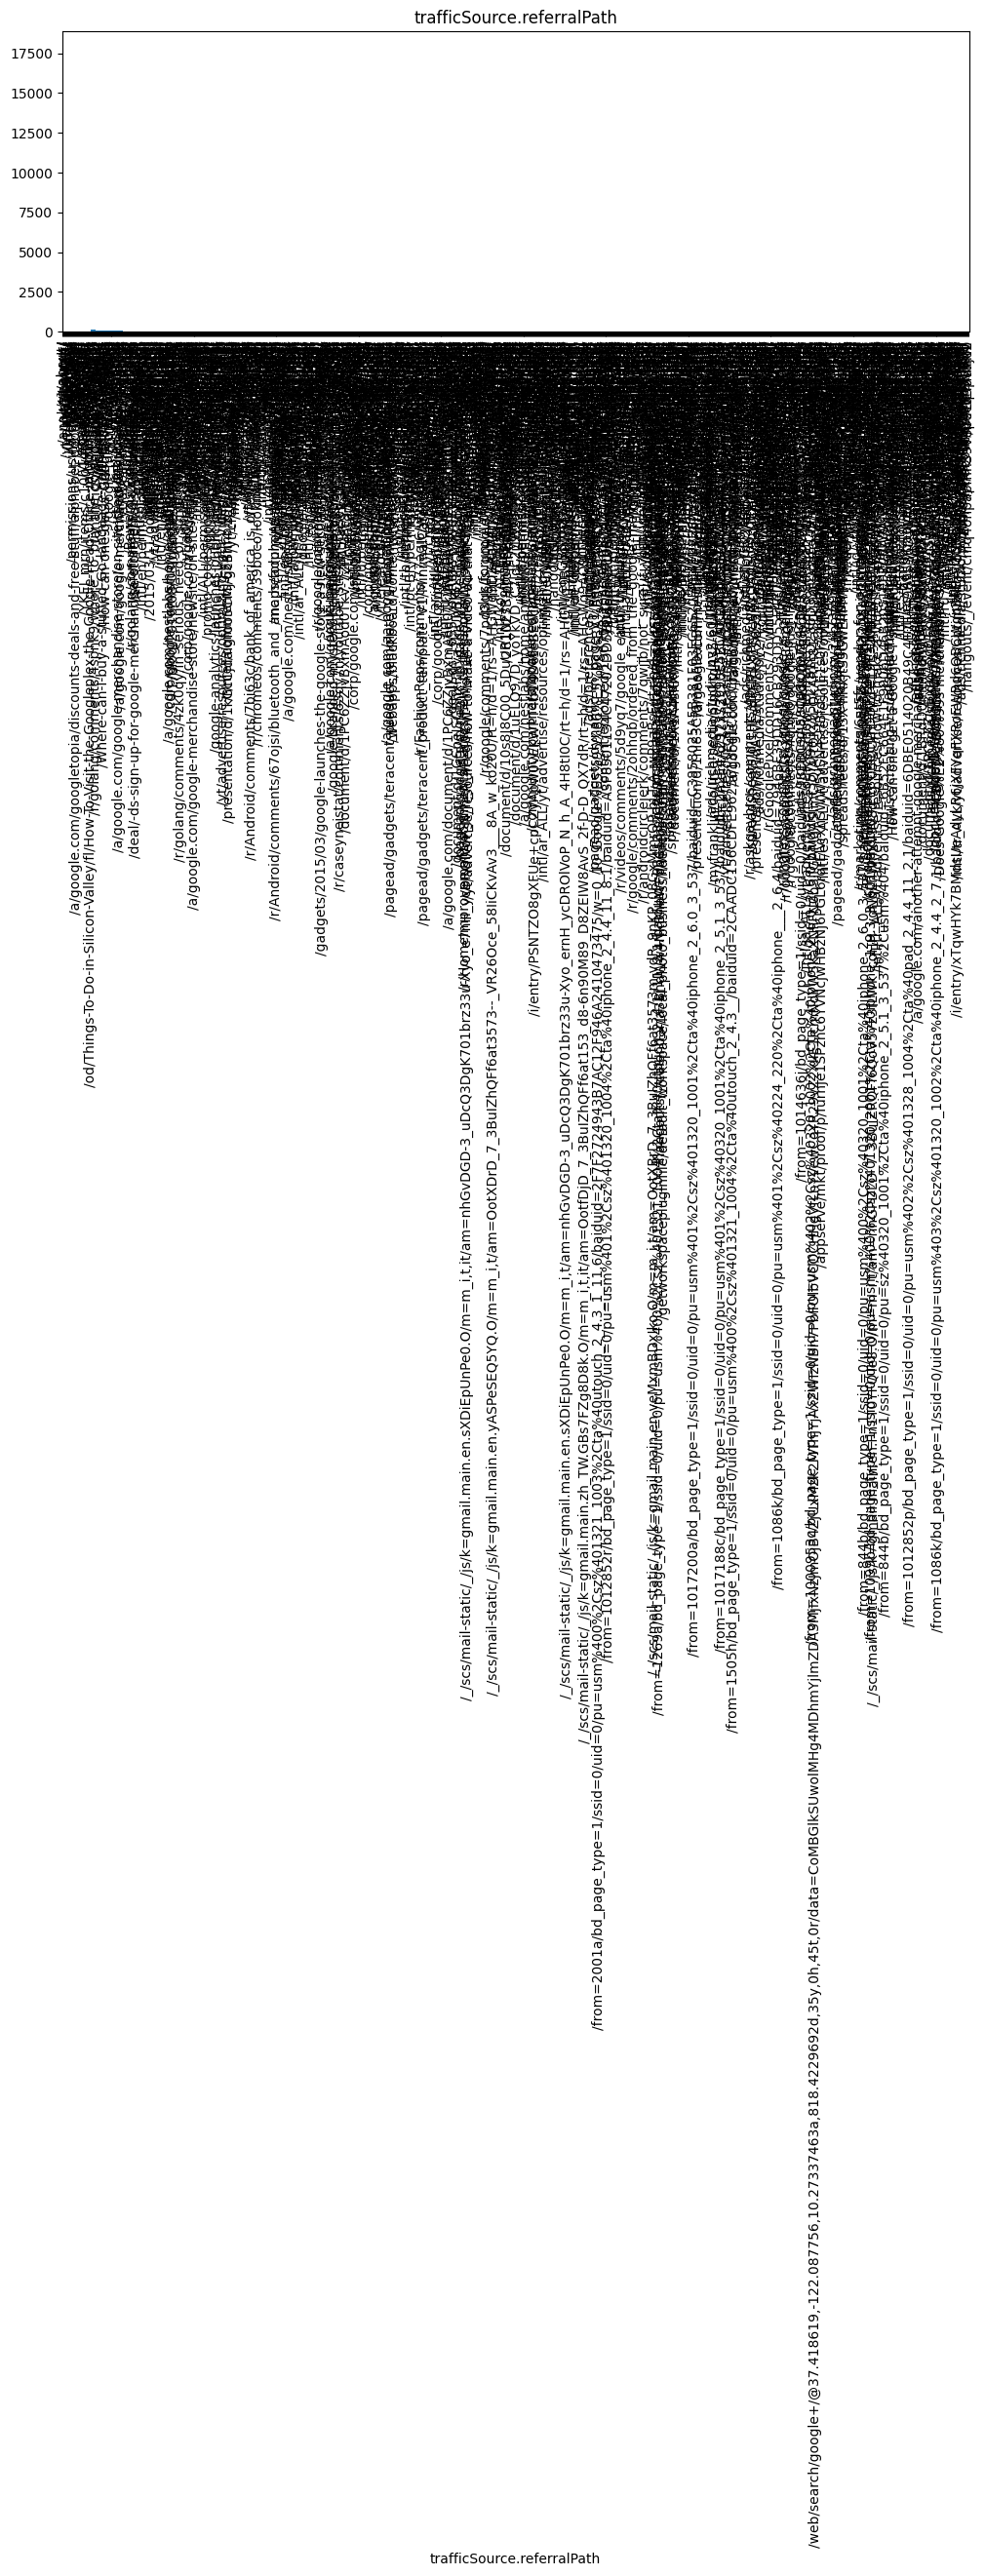

In [52]:
df_train['trafficSource.referralPath'].value_counts().plot(kind='bar', figsize=(12,4), title='trafficSource.referralPath')
plt.show()

In [53]:
df_train['trafficSource.referralPath'] = df_train['trafficSource.referralPath'].fillna('not provided')
df_test['trafficSource.referralPath'] = df_test['trafficSource.referralPath'].fillna('not provided')

# deviceType

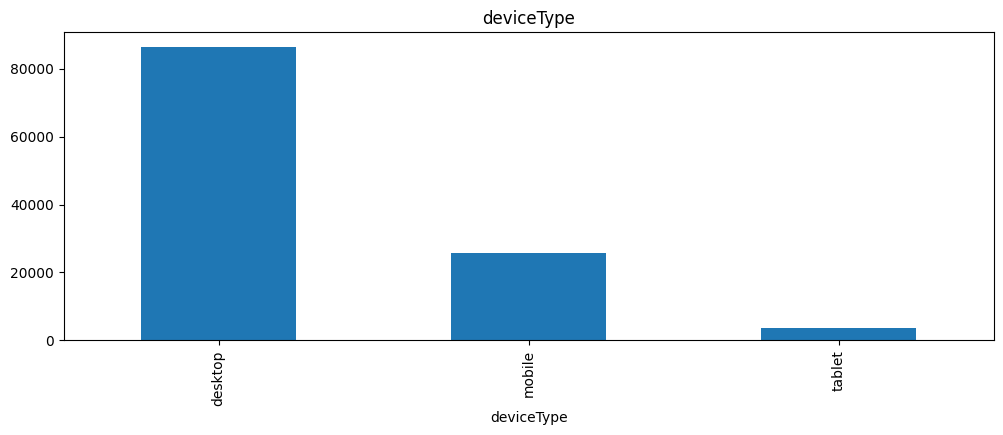

In [54]:
df_train['deviceType'].value_counts().plot(kind='bar', figsize=(12,4), title='deviceType')
plt.show()

# userChannel

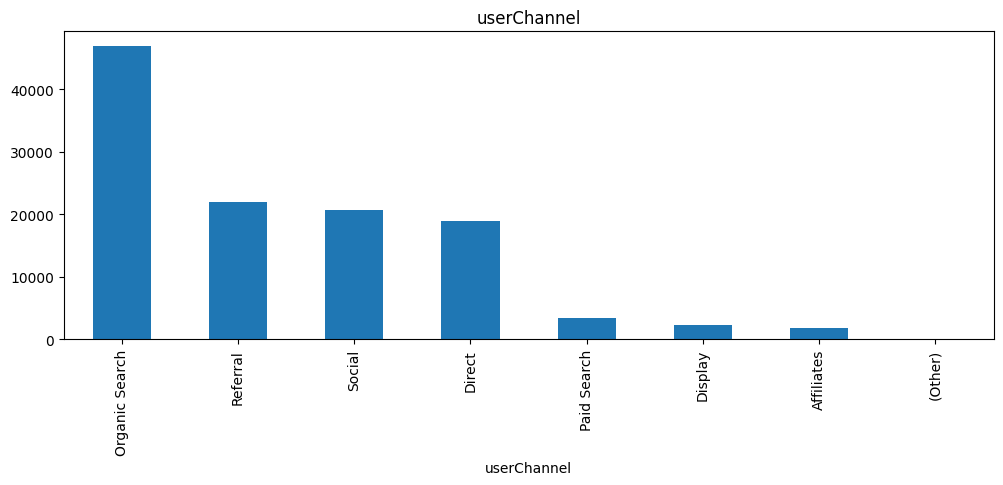

In [55]:
df_train['userChannel'].value_counts().plot(kind='bar', figsize=(12,4), title='userChannel')
plt.show()

#  geoNetwork.continent

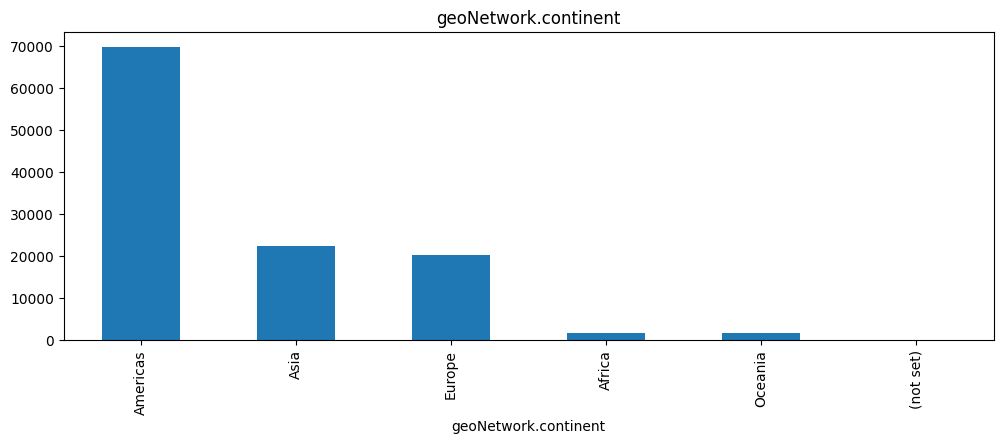

In [56]:
df_train['geoNetwork.continent'].value_counts().plot(kind='bar', figsize=(12,4), title='geoNetwork.continent')
plt.show()

# 3.7 Removing Duplicates form train data¶


In [57]:
df_train.drop_duplicates(subset=df_train.columns.tolist(), inplace=True)
print("Dublicate rows Removed")
print("Updated shape is",df_train.shape)

Dublicate rows Removed
Updated shape is (115783, 38)


# 3.8 Convert each boolean column to int

In [58]:
bool_cols = []

for col in df_train.columns:
    if df_train[col].dtype == 'bool':
        bool_cols.append(col)

print("Boolean columns to convert:", bool_cols)


for col in bool_cols:
    df_train[col] = df_train[col].astype(int)
    df_test[col] = df_test[col].astype(int)
    print(f"Converted '{col}' to int.")

Boolean columns to convert: ['trafficSource.isTrueDirect', 'device.isMobile']
Converted 'trafficSource.isTrueDirect' to int.
Converted 'device.isMobile' to int.


# 3.9 Checking Correlation

<Axes: >

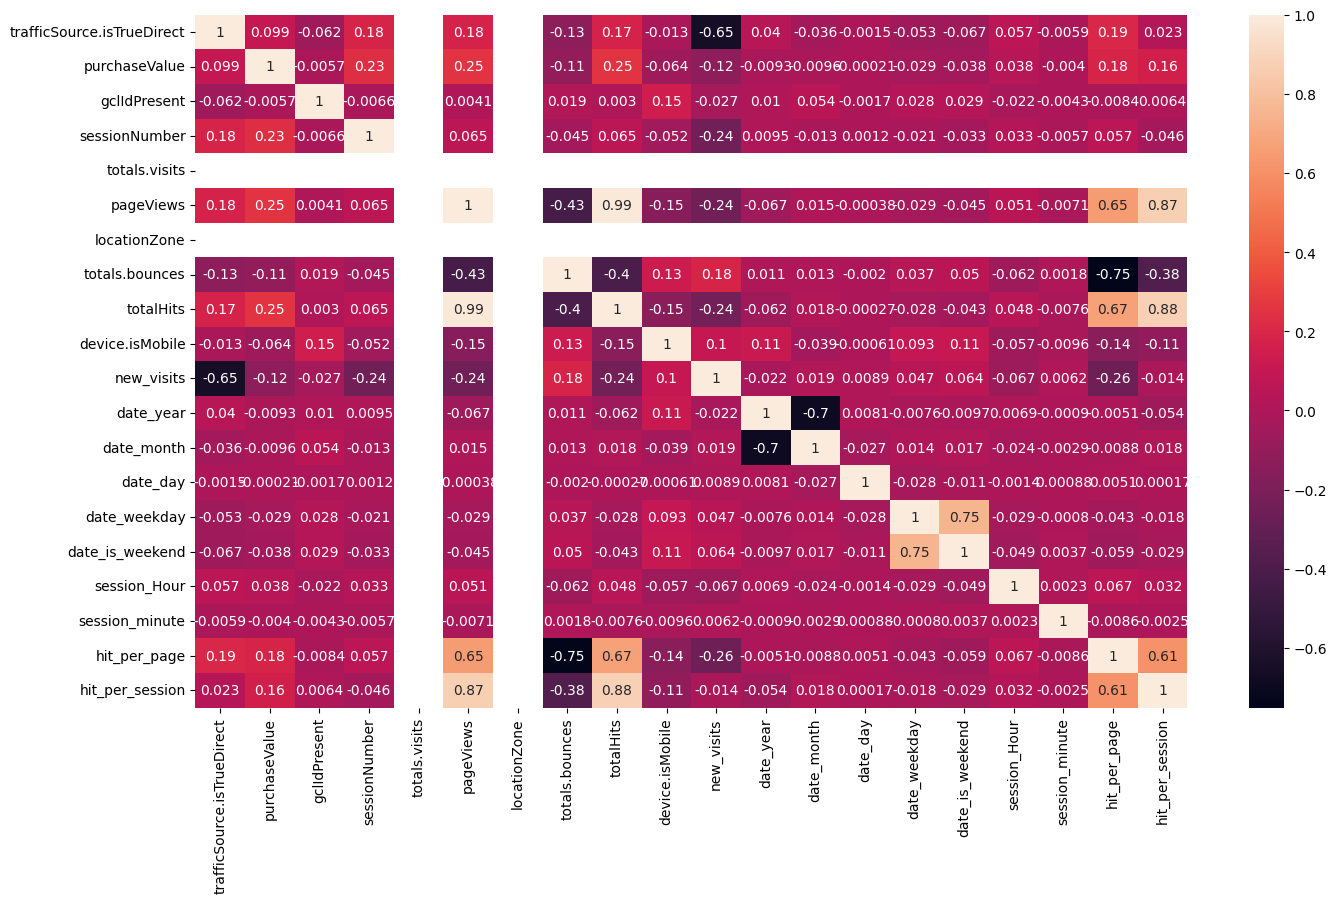

In [59]:
numeric = df_train.select_dtypes(include=['int64','int32','float32','float64']).columns
corr_matrix = df_train[numeric].corr()
plt.figure(figsize=(16,9))
sns.heatmap(corr_matrix, annot= True)

# 4. **Spiting**

# 4.1 Seperating Target and feautures

In [60]:
x_train =  df_train.drop(columns=['purchaseValue'])
y_train = df_train['purchaseValue']

# 4.2 seperation of Numerical and Categorical columns

In [61]:
num_cols = x_train.select_dtypes(include=['int64','int32','float32','float64']).columns.tolist()
print('Total Numerical Features is Train data',len(num_cols))

print('-')
num_cols_to_scale = [col for col in num_cols if df_train[col].nunique() > 2]
print('Number of Numerical Features to scale in Train data',len(num_cols_to_scale))
print(num_cols_to_scale)

print('-')
cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()
print('Number of Categorical Features of Train Data',len(cat_cols))
print(cat_cols)

Total Numerical Features is Train data 19
-
Number of Numerical Features to scale in Train data 11
['sessionNumber', 'pageViews', 'totalHits', 'date_year', 'date_month', 'date_day', 'date_weekday', 'session_Hour', 'session_minute', 'hit_per_page', 'hit_per_session']
-
Number of Categorical Features of Train Data 18
['browser', 'trafficSource.keyword', 'geoCluster', 'trafficSource.campaign', 'geoNetwork.networkDomain', 'geoNetwork.region', 'trafficSource', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'locationCountry', 'geoNetwork.city', 'geoNetwork.metro', 'trafficSource.referralPath', 'deviceType', 'userChannel', 'geoNetwork.continent', 'session_TimeOfDay']


# 4.3 seperating Low and High cardinal Columns

In [62]:
high_card_threshold = 10

low_card_cols = [col for col in cat_cols if x_train[col].nunique() <= high_card_threshold]
high_card_cols = [col for col in cat_cols if x_train[col].nunique() > high_card_threshold]


print('Number of low_card_cols of Train data',len(low_card_cols))
print("Low cardinality categorical columns:", low_card_cols)
print('-')
print('Number of high_card_cols of Train data',len(high_card_cols))
print("High cardinality categorical columns:", high_card_cols)

Number of low_card_cols of Train data 7
Low cardinality categorical columns: ['geoCluster', 'geoNetwork.networkDomain', 'trafficSource.medium', 'deviceType', 'userChannel', 'geoNetwork.continent', 'session_TimeOfDay']
-
Number of high_card_cols of Train data 11
High cardinality categorical columns: ['browser', 'trafficSource.keyword', 'trafficSource.campaign', 'geoNetwork.region', 'trafficSource', 'os', 'geoNetwork.subContinent', 'locationCountry', 'geoNetwork.city', 'geoNetwork.metro', 'trafficSource.referralPath']


# 4.4  Spliting into train and validation set

In [63]:
X_train, X_val, Y_train, Y_val = train_test_split(
    x_train, y_train, 
    test_size=0.2,          
    random_state=42)  

print('X_train shape',X_train.shape)
print('Y_train shape',Y_train.shape)
print('X_val shape',X_val.shape)
print('Y_val shape',Y_val.shape)

X_train shape (92626, 37)
Y_train shape (92626,)
X_val shape (23157, 37)
Y_val shape (23157,)


# 5. **Pipeline and Transformation**

In [64]:
num_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])


low_card_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

high_card_pipeline = Pipeline([
    ('target', TargetEncoder())
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols_to_scale),
    ('low_cat', low_card_pipeline, low_card_cols),
    ('high_cat', high_card_pipeline, high_card_cols)
],remainder='passthrough')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['sessionNumber', 'pageViews', 'totalHits',
                                  'date_year', 'date_month', 'date_day',
                                  'date_weekday', 'session_Hour',
                                  'session_minute', 'hit_per_page',
                                  'hit_per_session']),
                                ('low_cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=Fa...
                                  'trafficSource.medium', 'deviceType',
                                  'userChannel', 'geoNetwork.continent',
                                  'session_TimeOfDay']),
                                ('high_cat',
                                 Pipeline(steps=[('target', TargetEncoder())]),
                                 ['browser', 'trafficSource.keyword',
                                  'trafficSource.campaign', 'geoNetwork.region',
                                  'trafficSource', 'os',
                                  'geoNetwork.subContinent', 'locationCountry',
                                  'geoNetwork.city', 'geoNetwork.metro',
                                  'trafficSource.referralPath'])])

In [65]:
preprocessor.fit(X_train,Y_train)

X_train_transformed = preprocessor.transform(X_train)
X_valid_transformed = preprocessor.transform(X_val)
df_test_transformed = preprocessor.transform(df_test)


print('X_train_transformed shape is ',X_train_transformed.shape)
print('X_valid_transformed shape is ',X_valid_transformed.shape)
print('df_test_transformed shape is ',df_test_transformed.shape)

X_train_transformed shape is  (92626, 66)
X_valid_transformed shape is  (23157, 66)
df_test_transformed shape is  (29006, 66)


# 6. **Fitting Models**

In [66]:
# models = [
#     ('Linear Regression', LinearRegression()),
#     ('Ridge', Ridge(random_state=42)),
#     ('Lasso', Lasso(random_state=42)),
#     ('Random Forest', RandomForestRegressor(random_state=42,n_jobs = -1)),
#     ('XGBoost', XGBRegressor(random_state=42,n_jobs=-1)),
#     ('LightGBM', LGBMRegressor(random_state=42,verbosity=-1)),
#     ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
#     ('K-Neighbors', KNeighborsRegressor())
# ]

# results = []
# for name, model in models:
#     scores = cross_val_score(model, X_train_transformed, Y_train, cv=5, scoring='r2')
#     results.append((name, scores.mean()))
#     print(f"{name}: Average R2 Score = {scores.mean():.4f}")

Linear Regression: Average R2 Score = 0.1337
Ridge: Average R2 Score = 0.1338
Lasso: Average R2 Score = 0.1337
Random Forest: Average R2 Score = 0.4383
XGBoost: Average R2 Score = 0.4050
LightGBM: Average R2 Score = 0.3171
Gradient Boosting: Average R2 Score = 0.3399
K-Neighbors: Average R2 Score = -0.0934

# 7. **Tuning Models**

# 7.1 Tuning RandomForestRegressor

In [67]:
# param_dist = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': [1.0, 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }


# rf = RandomForestRegressor(random_state=42)
# random_search_rf = random_search = RandomizedSearchCV(
#     rf, param_distributions=param_dist,
#     n_iter=50, scoring='r2', cv=5, verbose= 0, n_jobs=-1, random_state=42
# )
# random_search_rf.fit(X_train_transformed, Y_train)

# print("Best parameters:", random_search_rf.best_params_)
# print("Best cross-validated R2 score:", random_search_rf.best_score_)

# 7.2 Tuning XGBRegresssor

In [68]:

# param_dist = {
#     'n_estimators': randint(100, 2000),
#     'max_depth': randint(3, 12),
#     'learning_rate': uniform(0.01, 0.2),
#     'subsample': uniform(0.5, 1.0),
#     'colsample_bytree': uniform(0.5, 1.0),
# }

# xgb = XGBRegressor(random_state=42)
# random_search = RandomizedSearchCV(
#     xgb, param_distributions=param_dist,
#     n_iter=50, scoring='r2', cv=5, verbose=0, n_jobs=-1, random_state=42
# )
# random_search.fit(X_train_transformed, Y_train)

# print("Best parameters:", random_search.best_params_)
# print("Best cross-validated R2 score:", random_search.best_score_)

Best parameters: {'colsample_bytree': 0.804781258158029, 'learning_rate': 0.04293117062858835, 'max_depth': 11, 'n_estimators': 417, 'subsample': 0.7221078104707302}
Best cross-validated R2 score: 0.544964812606308

# 7.2 Tuning GradientBoostingRegressor

In [69]:
# param_dist = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [3, 4, 5, 6, 8, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 3, 5],
#     'max_features': ['auto', 'sqrt', 'log2', None]
# }


# gbr = GradientBoostingRegressor(random_state=42)
# random_search = RandomizedSearchCV(
#     gbr,param_distributions=param_dist,
#     n_iter=50,scoring='r2',cv=5,verbose=1,n_jobs=-1,random_state=42
# )
# random_search.fit(X_train_transformed, Y_train)

# print("Best parameters:", random_search.best_params_)
# print("Best cross-validated R² score:", random_search.best_score_)

# 8. **Transforming full data**

In [70]:
preprocessor.fit(x_train,y_train)

final_x_train = preprocessor.transform(x_train)
final_x_test = preprocessor.transform(df_test)

# 9. **Choosing the Best Model and Predicting**

In [71]:
best_model =  XGBRegressor(
    colsample_bytree=0.804781258158029,
    learning_rate=0.04293117062858835,
    max_depth=11,
    n_estimators=1000,
    subsample=0.7221078104707302,
    random_state=42,
    n_jobs=-1
)


cv_scores = cross_val_score(best_model, X_train_transformed, Y_train, cv=5, scoring='r2')


print("Cross-Validation R² scores:", cv_scores)
print("Average CV R² score:", np.mean(cv_scores))

Cross-Validation R² scores: [0.57660713 0.26609731 0.65632124 0.59583495 0.66054287]
Average CV R² score: 0.5510806988687678


Cross-Validation R² scores: [0.57439022 0.26226729 0.6521125  0.58091383 0.65514022]
Average CV R² score: 0.544964812606308

In [72]:
best_model.fit(final_x_train, y_train)
predictions = best_model.predict(final_x_test)
predictions

array([ 3.3295126e+07,  1.1357216e+07, -9.6060553e+02, ...,
        3.2553876e+07,  1.3689700e+04,  1.9990375e+06], dtype=float32)

# 10. **Submiting the predictions**

In [73]:
submission = pd.DataFrame({'id': range(0,final_x_test.shape[0]),'purchaseValue': predictions})


submission.to_csv('submission.csv', index=False)
